In [32]:
# Dataset testing

import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import sigpy
import pynufft
import skimage
import os
import multiprocessing as mp
from multiprocessing import Pool
from PIL import Image
import tqdm
import glob
import seaborn as sns

from training.dataset import *
from dnnlib.util import *
from torch_utils import distributed as dist
from torch_utils import misc
import training.trajectory as trajectory
import training.visualize as visualize
import generate_conditional

device = torch.device('cuda')

import torchvision

import time

In [33]:
def make_trajectory_custom(matsize, undersampling=1, interleaves=1, alpha=1, freqcrop = True):

    fov = .22 #in meters
    # adjustedshape = np.power(matsize[0]**2+matsize[1]**2,0.5)
    adjustedshape = matsize[0]
    frequency_encode_undersampling = 1
    max_gradient_amp = 0.045 / 2#T/m  4.5 G/cm, or 2.2 G/cm       - Brian uses 0.040
    max_slew_rate = 0.2 * 1000 #T/m/s

    # u = .0365 / undersampling * (1-2*(((1/alpha)**4)-(1/alpha)**2)) # Empirically determined as a decent approximation for maintaining a steady effective undersampling rate
    # print(u)
    # u = u*10
    u = undersampling
    


    # points = sigpy.mri.spiral(fov, 
    #                         adjustedshape, 
    #                         frequency_encode_undersampling, 
    #                         u, 
    #                         interleaves, 
    #                         alpha, 
    #                         max_gradient_amp, 
    #                         max_slew_rate)
    
    points, t, dt, Tend, Dt = spiral(fov, 
                            adjustedshape, 
                            frequency_encode_undersampling, 
                            u, 
                            interleaves, 
                            alpha, 
                            max_gradient_amp, 
                            max_slew_rate)
    
    if freqcrop:
        precrop_points = points.shape[0]
        points = np.delete(points, np.where((np.hypot(points[:,0],points[:,1]) >= matsize[0]/2)), axis=0) # circle
        # points = np.asarray([i for i in points if -matsize[0]/2<=i[0]<=matsize[0]/2 and -matsize[1]/2<=i[1]<=matsize[1]/2]) # square 
        postcrop_points = points.shape[0]
        crop_accel_factor = postcrop_points/precrop_points
        Tend = Tend*crop_accel_factor

    return points, t, dt, Tend, Dt


def spiral(fov, N, f_sampling, R, ninterleaves, alpha, gm, sm, gamma=2.678e8):
    """Generate variable density spiral trajectory.

    Args:
        fov (float): field of view in meters.
        N (int): effective matrix shape.
        f_sampling (float): undersampling factor in freq encoding direction.
        R (float): undersampling factor.
        ninterleaves (int): number of spiral interleaves
        alpha (float): variable density factor
        gm (float): maximum gradient amplitude (T/m)
        sm (float): maximum slew rate (T/m/s)
        gamma (float): gyromagnetic ratio in rad/T/s

    Returns:
        array: spiral coordinates.

    References:
        Dong-hyun Kim, Elfar Adalsteinsson, and Daniel M. Spielman.
        'Simple Analytic Variable Density Spiral Design.' MRM 2003.

    """
    
    res = fov / N

    lam = 0.5 / res  # in m**(-1)
    n = 1 / (1 - (1 - ninterleaves * R / fov / lam) ** (1 / alpha))
    w = 2 * np.pi * n
    Tea = lam * w / gamma / gm / (alpha + 1)  # in s
    Tes = np.sqrt(lam * w**2 / sm / gamma) / (alpha / 2 + 1)  # in s
    Ts2a = (
        Tes ** ((alpha + 1) / (alpha / 2 + 1))
        * (alpha / 2 + 1)
        / Tea
        / (alpha + 1)
    ) ** (
        1 + 2 / alpha
    )  # in s

    if Ts2a < Tes:
        tautrans = (Ts2a / Tes) ** (1 / (alpha / 2 + 1))

        def tau(t):
            return (t / Tes) ** (1 / (alpha / 2 + 1)) * (0 <= t) * (
                t <= Ts2a
            ) + ((t - Ts2a) / Tea + tautrans ** (alpha + 1)) ** (
                1 / (alpha + 1)
            ) * (
                t > Ts2a
            ) * (
                t <= Tea
            ) * (
                Tes >= Ts2a
            )

        Tend = Tea
    else:

        def tau(t):
            return (t / Tes) ** (1 / (alpha / 2 + 1)) * (0 <= t) * (t <= Tes)

        Tend = Tes

    def k(t):
        return lam * tau(t) ** alpha * np.exp(w * tau(t) * 1j)

    dt = Tea * 1e-4  # in s

    Dt = dt * f_sampling / fov / abs(k(Tea) - k(Tea - dt))  # in s

    t = np.linspace(0, Tend, int(Tend / Dt))
    kt = k(t)  # in rad

    # generating cloned interleaves
    k = kt
    for i in range(1, ninterleaves):
        k = np.hstack((k, kt[0:] * np.exp(2 * np.pi * 1j * i / ninterleaves)))

    k = np.stack((np.real(k), np.imag(k)), axis=1)

    return k, t, dt, Tend, Dt

In [34]:
140 / 320 * 256 / 30

3.7333333333333334

In [88]:
def parameterize_acceleration_factor(accel_target = 20, interleaves = 4, alpha = 1.2, matsize = 256, reference_time = 112, threshold=0.001, correction = 1, freqcrop = True):
    accel = accel_target*(threshold+1.1)
    undersampling = 1 * matsize / 256 * correction
    iter = 0
    while abs(accel_target-accel) > (threshold * accel_target):
        points, t, dt, Tend, Dt = make_trajectory_custom((matsize,matsize), undersampling=undersampling, interleaves=interleaves, alpha=alpha, freqcrop = freqcrop)
        
        if accel_target-accel > 0:
            undersampling += 0.01 * np.clip(accel_target-accel,0.0001,10) * (1000/(1000+iter))
        else:
            undersampling += 0.01 * np.clip(accel_target-accel,-0.0001,-10) * (1000/(1000+iter))
                        
        accel = reference_time / (Tend*interleaves)
        iter += 1
        
        # print(f'Undersampling: {undersampling}, Acceleration: {accel}')
        
    print(f'{iter} iterations')
    return undersampling, interleaves, alpha, accel

In [36]:
np.clip(1.4, 1,2)

1.4

In [37]:
def make_trajectory_fixed_accel(matsize, reference_time, acceleration=1, interleaves=1, alpha=1, threshold = 0.01, freqcrop = True):
    undersampling, _, _, _ = parameterize_acceleration_factor(accel_target = acceleration, interleaves = interleaves, alpha = alpha, matsize = matsize, reference_time = reference_time, threshold=threshold, freqcrop = freqcrop)
    points, _, _, Tend, Dt = make_trajectory_custom((matsize,matsize), undersampling=undersampling, interleaves=interleaves, alpha=alpha, freqcrop = freqcrop)
    print(f'Undersampling trajectory input: {undersampling}')
    return points, Dt, interleaves, alpha, Tend

In [38]:
def plot_trajectory_gradients(points, Dt, interleaves, alpha, Tend):
    import seaborn as sns
    # sns.set_palette('Greens_r')
    sns.set_palette('Reds_r')
    # sns.set_palette('Spectral')

    fig, ax = plt.subplots(1,1,figsize=(6,2))
    if interleaves == 1:
        width = 0.1
    else:
        width = 0.3
    # extent = 4800
    ax.plot(Dt*np.array(list(range(points.shape[0])[:points.shape[0]//interleaves])),points[:points.shape[0]//interleaves], linewidth=width, alpha=1)
    ax.plot(Dt*np.array(list(range(points.shape[0]))),points, linewidth=0.1, alpha=1)

    # ax.plot(Dt*np.array(list(range(points.shape[0]))),points[:,1], linewidth=0.2, alpha=1, color='orange')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('kx, ky (1/m)')
    ax.text(0.995, 0.19, 'Interleaves: {}\nAlpha:   {}\nGradient Amplitude Cap: {} T/m\nGradient Slew Rate Cap: {} T/m/ms\nFOV: {} mm\nTime Interleave: {} ms\n'.format(interleaves, alpha, 0.045, 0.2, 220, str(round(Tend * 1000, 3))), 
            horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, size=8)

In [39]:
def plot_trajectory_spiral(points, interleaves):
    if interleaves == 1:
        width = 0.1
    else:
        width = 0.3
    g = sns.JointGrid(height=5)
    sns.lineplot(x=points[:points.shape[0]//interleaves,0],y=points[:points.shape[0]//interleaves,1], ax=g.ax_joint, sort=False, alpha=1, linewidth=width)
    for i in range(1,interleaves):
        sns.lineplot(x=points[points.shape[0]//interleaves * i:points.shape[0]//interleaves * (i+1),0],y=points[points.shape[0]//interleaves * i:points.shape[0]//interleaves * (i+1),1],
                    ax=g.ax_joint, sort=False, alpha=1, linewidth=0.1)
    sns.histplot(x=points[:,0], alpha = 0.7, linewidth=0.1, ax=g.ax_marg_x)
    sns.histplot(y=points[:,1], alpha = 0.7, linewidth=0.1, ax=g.ax_marg_y)
    # sns.kdeplot(x=points[:points.shape[0]//interleaves,0],y=points[:points.shape[0]//interleaves,1], color="r", alpha=.1, levels=10, ax=g.ax_joint)
    # sns.scatterplot(x=points[:points.shape[0]//interleaves,0],y=points[:points.shape[0]//interleaves,1], color="b", marker = '.', s=10, alpha=0.5, ax=g.ax_joint, zorder=100)

    g.ax_joint.set_xlabel('kx (1/m)')
    g.ax_joint.set_ylabel('ky (1/m)')

# Spiral Trajectory Undersampled

In [171]:
accel_target = 1
interleaves = 1
alpha = 1
matsize = 256
reference_time = 0.02
# matsize = 128
# reference_time = 1.9

parameterize_acceleration_factor(accel_target = accel_target, interleaves = interleaves, alpha = alpha, matsize = matsize, reference_time = reference_time, threshold=0.001)
points, Dt, interleaves, alpha, Tend = make_trajectory_fixed_accel(matsize, reference_time, acceleration=accel_target, interleaves=interleaves, alpha=alpha,  threshold=0.001)

206 iterations
206 iterations
Undersampling trajectory input: 0.2880434212531511


In [172]:
Tend * interleaves

0.020019906396101798

In [173]:
reference_time / (Tend * interleaves)

0.99900566987138

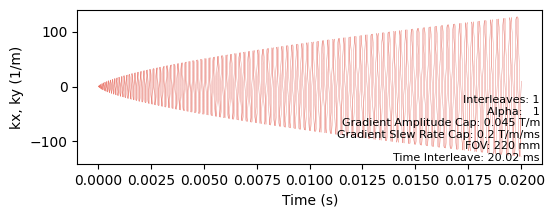

In [174]:
plot_trajectory_gradients(points, Dt, interleaves, alpha, Tend)

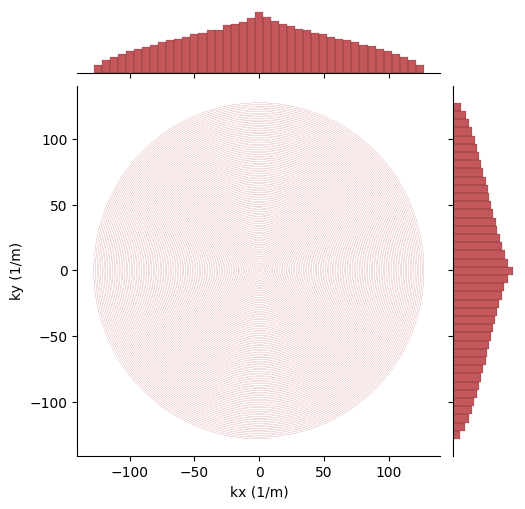

In [175]:
plot_trajectory_spiral(points, interleaves)

In [70]:
Dt

9.439883943293794e-07

In [71]:
points.shape

(21182, 2)

In [72]:
256**2

65536

In [73]:
points.shape

(21182, 2)

In [74]:
# Dwell time 
Tend * interleaves / points.shape[0]

9.441858698957416e-07

In [75]:
# Noise-matched acceleration rate:
reference_time * (12e-6/Dt)

0.2542404138034969

# Spiral Trajectory Nyquist

In [76]:
# points, Dt, interleaves, alpha, Tend = make_trajectory_fixed_accel(matsize, reference_time, acceleration=accel_target, interleaves=interleaves, alpha=alpha,  threshold=0.002)
# Tend

In [77]:
# plot_trajectory_spiral(points, interleaves)

In [78]:
points, t, dt, Tend, Dt = make_trajectory_custom((matsize,matsize), undersampling=1, interleaves=interleaves, alpha=alpha, freqcrop = False)

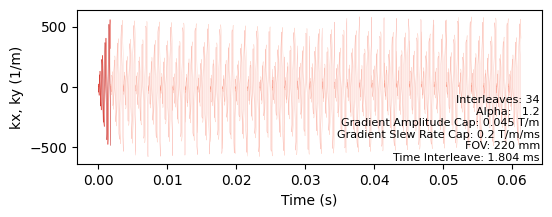

In [79]:
plot_trajectory_gradients(points, Dt, interleaves, alpha, Tend)

In [80]:
Tend * interleaves / points.shape[0]

9.431556878139748e-07

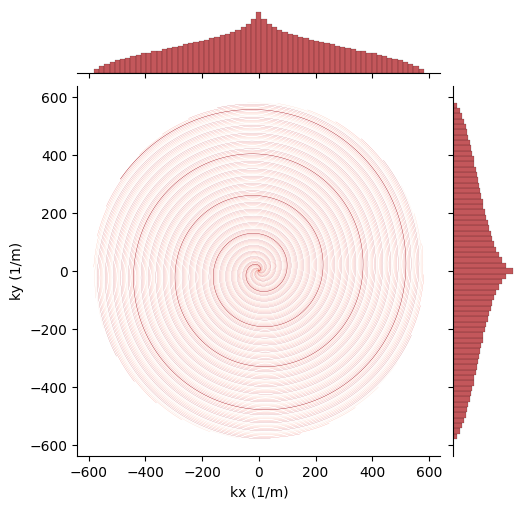

In [81]:
plot_trajectory_spiral(points, interleaves)

In [82]:
# Scan time / slice:
(Tend * interleaves) / reference_time

3.0672366123398276

# Hyperparameter search

Range of interleaves: 1 - 90, with emphasis on fibbonacci numbers:
[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]

1-21 all, then
23 - 144 logrithmically, 

In [154]:
interleaves = np.unique(np.geomspace(1,144, num=32).astype(int))
print(len(interleaves))
interleaves

25


array([  1,   2,   3,   4,   5,   6,   8,   9,  11,  13,  15,  17,  21,
        24,  28,  34,  39,  46,  55,  64,  75,  89, 104, 122, 144])

In [146]:
alphas = np.geomspace(1, 10, num=25)
alphas

array([ 1.        ,  1.10069417,  1.21152766,  1.33352143,  1.46779927,
        1.6155981 ,  1.77827941,  1.95734178,  2.15443469,  2.37137371,
        2.61015722,  2.87298483,  3.16227766,  3.48070059,  3.83118685,
        4.21696503,  4.64158883,  5.10896977,  5.62341325,  6.18965819,
        6.81292069,  7.49894209,  8.25404185,  9.08517576, 10.        ])

In [178]:
def load_raw_kspace(fname):
    with open(fname, 'rb') as f:
        kspace = np.load(f)
        assert kspace.dtype == np.float32, 'kspace datatype should be float32, half precision results in a significant drop in im quality'
        assert kspace.shape[0] == kspace.shape[1], f'shape kspace = {kspace.shape}, file = {fname}'
    if kspace.ndim == 2:
        kspace = kspace[:, :, np.newaxis, np.newaxis] # H,W => H,W,complex,channel
    if kspace.ndim == 3: 
        kspace = kspace[:, :, :, np.newaxis] # H,W,complex => H,W,complex,channel
    kspace = kspace.transpose(3, 2, 0, 1) # H,W,complex,channel => channel,complex,H,W
    kspace = kspace[:,0] + kspace[:,1] * 1j # convert to [channel, h, w] as complex number
    
    return kspace

def load_raw_image(fname, accel_target, interleaves, alpha, matsize, reference_time):
    
    kspace = load_raw_kspace(fname)    
    points, Dt, interleaves, alpha, Tend = make_trajectory_fixed_accel(matsize, reference_time, acceleration=accel_target, interleaves=interleaves, alpha=alpha,  threshold=0.001)

    # initialize nufftobj
    nufftobj = trajectory.prealloc_nufft(kspace, points)

    # compute the values via complex interpolation, compute the image prior via inverse nufft, and compute the ground truth image
    y = trajectory.interpolate_values(points,kspace) #for complex interpolation
    prior = trajectory.inverse_nufft(y, nufftobj, maxiter=100)
    image = sigpy.ifft(kspace, axes=(-1,-2))

    # perform std normalization
    prior = trajectory.intensity_normalization(prior)
    image = trajectory.intensity_normalization(image)

    return np.stack((image, prior),axis=0), {'kspace':kspace, 'y':y, 'points':points}

def evaluate_trajectory(net, parcel, seed=0):
    torch.manual_seed(seed)
    
    batch = parcel[0].shape[0]
    latents = torch.randn([1, net.img_channels, net.img_resolution, net.img_resolution], device=device)
    priors = parcel[1].to(device)
    kspace = parcel[3]['kspace'].to(device)

    y = np.array(parcel[3]['y'])
    points = np.array(parcel[3]['points'])
    
    # No guidance
    for s in tqdm.tqdm(chs(net=net, latents=latents, priors=priors, kspace=kspace, num_steps=config['num_steps'], sigma_min=config['sigma_min'], sigma_max=config['sigma_max']), total=config['num_steps']):
        pass
    recon = trajectory.magphase_to_complex(s['denoised'])
    image_rss = trajectory.root_summed_squares(trajectory.float_to_complex(parcel[0]))[0]
    recon_rss = trajectory.root_summed_squares(recon)[0]
    return ssim(image_rss, recon_rss, data_range=np.amax(image_rss) - np.amin(image_rss))

def aggregate_results(datas, net, accel_target, interleaves, alphas, matsize, reference_time):
    ssims = np.zeros((len(interleaves), len(alphas)))
    for i, interleave in tqdm.tqdm(enumerate(interleaves)):
        for j, alpha in enumerate(alphas):
            ssim = 0
            for data in datas:
                parcel = load_raw_image(data, accel_target, interleave, alpha, matsize, reference_time)
                ssim += evaluate_trajectory(net, parcel, seed=0)
            ssims[i, j] = ssim / len(datas)
    return ssims